In [1]:
"""
RNN ile duygu dedektifi (sentiment analysis)
Problem tanımı: bir yorumun olumlu mu olumsuz mu olduğunu anlamak  (classification problem)
IMDB film yorumları veri seti ile bir metnin duygusal analizini gerçekleştirme
- this movie is awesome -> pozitif
- it was terrible -> negatif

RNN: Tekrarlayan sinir ağları, sıralı veriler üzerinde çalışıyor, metin gibi verilerde önceki bilgileri hatırlayarak sonraki tahminleri yapmaya çalışıyor
girdi: film -> çok -> kötüydü
bellek:
çıktı: anlam   anlam    olumsuz

veri seti : IMDB veri seti kullanılacak (olumlu ve olumsuz)
- 50000 adet film yorumu
- 0 negatif, 1 pozitif


"""
# import libraries
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential # base model
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding, Dropout
from tensorflow.keras.datasets import imdb # veri seti
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Kelime dağarcığımızın sınırı (En sık kullanılan 10.000 kelimeyi alacağız)
# Diğer nadir kelimeler modelin kafasını karıştırmasın diye yoksayılır.
num_words = 10000

# Veri setini yükle (Eğitim ve Test olarak ayrılmış halde gelir)
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

print(f"Eğitim verisi sayısı: {len(X_train)}")
print(f"Test verisi sayısı: {len(X_test)}")

Eğitim verisi sayısı: 25000
Test verisi sayısı: 25000


In [3]:
# Örnek bir yorumu inceleyelim (Sayısal hali)
print("--- Sayısal Hal (Bilgisayarın Gördüğü) ---")
print(X_train[0])

# Etiketine bakalım (1: Pozitif, 0: Negatif)
print(f"\nEtiket (Duygu): {y_train[0]}")

--- Sayısal Hal (Bilgisayarın Gördüğü) ---
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]

Etiket (Duygu): 

In [4]:
# Her yorumu sabit bir uzunluğa getirelim
maxlen = 100  # Her yorumu 100 kelime ile sınırlayalım

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

print("Padding işleminden sonra ilk yorumun yeni hali:")
print(X_train[0])
# Dikkat edersen artık hepsi aynı uzunlukta birer vektör oldu.

Padding işleminden sonra ilk yorumun yeni hali:
[1415   33    6   22   12  215   28   77   52    5   14  407   16   82
    2    8    4  107  117 5952   15  256    4    2    7 3766    5  723
   36   71   43  530  476   26  400  317   46    7    4    2 1029   13
  104   88    4  381   15  297   98   32 2071   56   26  141    6  194
 7486   18    4  226   22   21  134  476   26  480    5  144   30 5535
   18   51   36   28  224   92   25  104    4  226   65   16   38 1334
   88   12   16  283    5   16 4472  113  103   32   15   16 5345   19
  178   32]


In [5]:
# 1. Modeli Başlat
model = Sequential()

# 2. Embedding Katmanı ekle
# input_dim=10000: Kelime dağarcığımız (num_words)
# output_dim=32: Her kelimeyi 32 uzunluğunda bir vektörle ifade et
# input_length=100: Her yorum 100 kelime uzunluğunda (padding yapmıştık)
model.add(Embedding(input_dim=10000, output_dim=32, input_length=100))

# 3. RNN Katmanı ekle
# units=32: 32 tane "hafıza hücresi" olsun.
model.add(SimpleRNN(units=32))
model.add(Dropout(0.5))

# 4. Çıktı Katmanı
# 1 nöron var çünkü sonuç ya 0 ya 1.
# aktivasyon='sigmoid' sonucun 0 ile 1 arasında olmasını sağlar.
model.add(Dense(1, activation='sigmoid'))

# Modelin özetine bakalım
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Modeli derle
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Eğitimi başlat (Fırını çalıştır)
# epochs=5: Veri setinin üzerinden 5 kere geç.
# batch_size=128: Her seferinde 128 yorumu aynı anda işle.
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2) # Verinin %20'sini doğrulama için ayır

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.5748 - loss: 0.6670 - val_accuracy: 0.7812 - val_loss: 0.4731
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8172 - loss: 0.4335 - val_accuracy: 0.7846 - val_loss: 0.4559
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8595 - loss: 0.3533 - val_accuracy: 0.8078 - val_loss: 0.4356
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8875 - loss: 0.2879 - val_accuracy: 0.7662 - val_loss: 0.6304
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9179 - loss: 0.2313 - val_accuracy: 0.8300 - val_loss: 0.4116


In [7]:
print("Model test ediliyor...")
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test Kaybı (Loss): {loss}")
print(f"Test Doğruluğu (Accuracy): %{accuracy * 100:.2f}")

Model test ediliyor...
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8264 - loss: 0.4113
Test Kaybı (Loss): 0.408249169588089
Test Doğruluğu (Accuracy): %82.82


In [8]:
model.save('duygu_dedektifi_rnn.h5')
print("Model başarıyla kaydedildi.")

Model başarıyla kaydedildi.


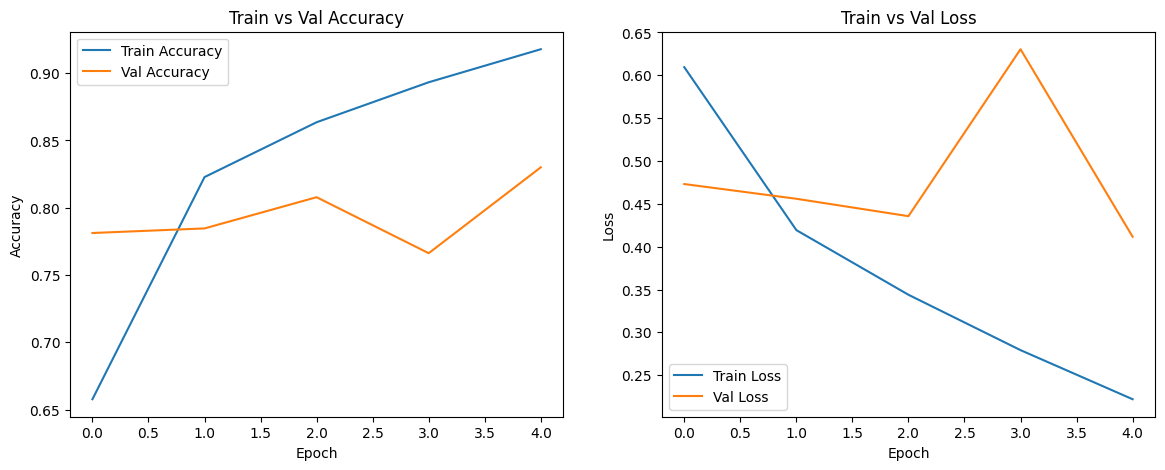

In [9]:
# Grafiklerin boyutunu ayarlayalım
plt.figure(figsize=(14, 5))

# --- 1. Grafik: Doğruluk (Accuracy) ---
plt.subplot(1, 2, 1) # 1 satır, 2 sütunluk alanın 1. grafiği
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Train vs Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# --- 2. Grafik: Kayıp (Loss) ---
plt.subplot(1, 2, 2) # 1 satır, 2 sütunluk alanın 2. grafiği
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [10]:
from tensorflow.keras.models import load_model

# 1. Modeli Dosyadan Yükle
yuklenen_model = load_model('duygu_dedektifi_rnn.h5')
print("Model diskten başarıyla yüklendi! Test başlıyor...\n")

# --- Hazırlıklar ---
word_index = imdb.get_word_index()

def tahmin_et_dosyadan(cumle, model_objesi):
    words = cumle.lower().split()
    encoded = []
    for word in words:
        try:
            # Kelime sözlükte varsa indeksini al (+3 Keras standardı)
            encoded.append(word_index.get(word, 0) + 3)
        except:
            encoded.append(2)

    encoded_padded = pad_sequences([encoded], maxlen=100)

    # Tahmin
    tahmin = model_objesi.predict(encoded_padded, verbose=0)[0][0]
    return tahmin

# --- TEST SENARYOLARI ---

# Senaryo 1: Pozitif Cümle
pozitif_cumle = "this film was amazing and really good i loved the acting"

# Senaryo 2: Negatif Cümle
negatif_cumle = "this movie was terrible and wasting my time very bad story"

# --- SONUÇLARI YAZDIRMA ---

# 1. Pozitif Testi
skor1 = tahmin_et_dosyadan(pozitif_cumle, yuklenen_model)
print(f"Yorum 1: '{pozitif_cumle}'")
print(f"Puan: {skor1:.4f}")
print(f"Karar: {'POZİTİF ✅' if skor1 > 0.5 else 'NEGATİF ❌'}")

print("-" * 30) # Araya çizgi çekelim

# 2. Negatif Testi
skor2 = tahmin_et_dosyadan(negatif_cumle, yuklenen_model)
print(f"Yorum 2: '{negatif_cumle}'")
print(f"Puan: {skor2:.4f}")
print(f"Karar: {'POZİTİF ✅' if skor2 > 0.5 else 'NEGATİF ❌'}")

Model diskten başarıyla yüklendi! Test başlıyor...

Yorum 1: 'this film was amazing and really good i loved the acting'
Puan: 0.9852
Karar: POZİTİF ✅
------------------------------
Yorum 2: 'this movie was terrible and wasting my time very bad story'
Puan: 0.1114
Karar: NEGATİF ❌
